In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import time as tm

# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import RenG, gain
from src.model_sys import RobotsSystem, disturbance, computePriccati
from src.plots import plot_trajectories, plot_traj_vs_time
from src.loss_functions import f_loss_states, f_loss_u, f_loss_ca, f_loss_obst
from src.utils import set_params_online

# Set the random seed for reproducibility
torch.manual_seed(68)
# Set the parameters and hyperparameters for the simulation
params = set_params_online()
min_dist, t_end, n_agents, x0, xbar, learning_rate, epochs, Q, alpha_u, alpha_ca, alpha_obst, n_xi, \
        l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew, Horizon, timeInstantOpt, sim_time, gainF, n_traj_ol = params

In [2]:
###########################################
# Define the system model
syst = RobotsSystem(xbar)
###########################################
# Define the controller model
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
amplifier = gain(gamma_bar)
ctl.load_state_dict(torch.load("trained_models/offline_mountains_ctl.pt", weights_only=False))
ctl.set_param()
amplifier.load_state_dict(torch.load("trained_models/offline_mountains_amp.pt", weights_only=False))

# Define the optimizer and its parameters{'params': OLs.parameters(), 'lr': 1e-3},
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)

Text(0.5, 1.0, 'closed loop disturbance w')

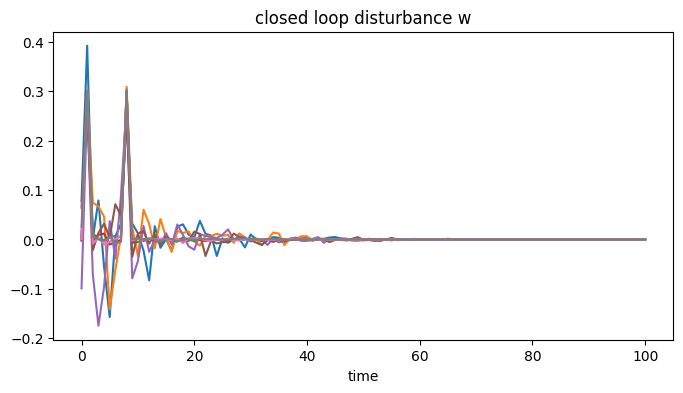

In [3]:
gamma_bar = amplifier.gamma.detach()

time = torch.linspace(0, sim_time, sim_time+1)

delta = 0.3
wmaxCL = wmax
w_inCL = torch.randn(sim_time + 1, syst.n)
w_in_CL = disturbance(time,w_inCL,wmax,decayw,maxtimew)
w_in_CL[1,:]= w_in_CL[1,:]+delta
w_in_CL[8,:]=w_in_CL[8,:]+delta

plt.figure(figsize=(4 * 2, 4))
plt.plot(time, w_in_CL)
plt.xlabel('time')
plt.title('closed loop disturbance w')
#plt.show()

------- Print pre-trained loop trajectories --------


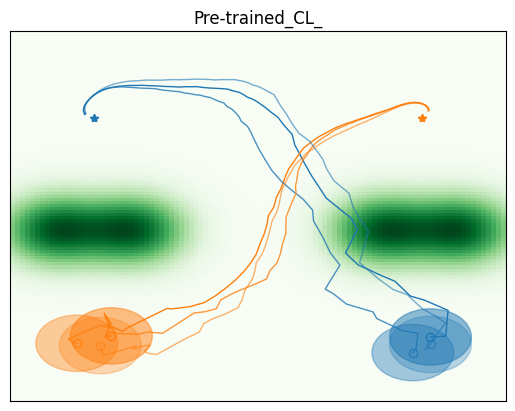

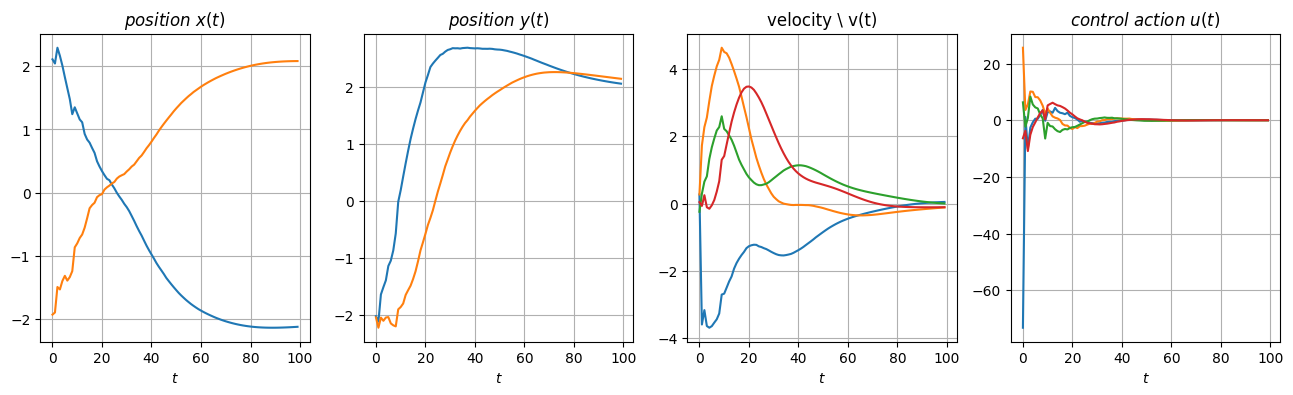

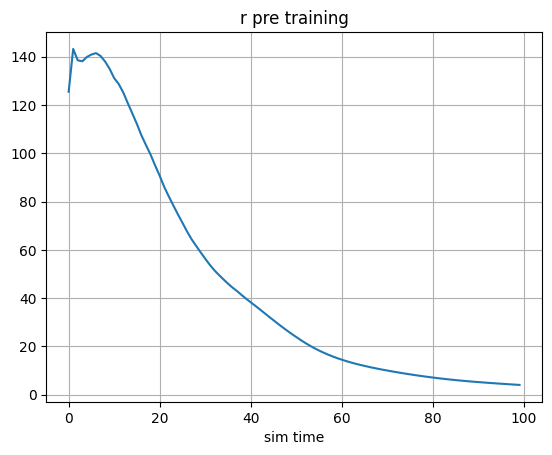

In [4]:
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print pre-trained loop trajectories --------")
# Generate random initial conditions for the trajectories
x_log_pre = torch.zeros(sim_time, syst.n,n_traj_ol)
u_log_pre = torch.zeros(sim_time, syst.m,n_traj_ol)
r_log_pre = torch.zeros(sim_time, 1)

for traj in range(n_traj_ol):
    devx0 = std_ini * torch.randn(x0.shape)
    w_in = torch.randn(sim_time + 1, syst.n)
    x = x0 + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0 - syst.xbar +devx0
    u, xi = ctl(0, w_REN, xi)
    usys = gamma_bar * u
    for t in range(sim_time):
        x_ = x
        if traj == 0:
            eps_pre = torch.norm(x-xbar)
            r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
        x_log_pre[t, :,traj] = x.detach()
        u_log_pre[t, :,traj] = usys.detach()
        w_syst = disturbance(t,w_in[t,:],wmaxCL,decayw,maxtimew)
        if t == 1 or t == 8:
            w_syst = w_syst + delta
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys)
        u, xi = ctl(t, w_REN, xi)
        usys = gamma_bar * u

plot_trajectories(x_log_pre, xbar, syst.n_agents, text="Pre-trained_CL_",save=False, filename="trajectories" ,circles=True, T=sim_time-1, obst=alpha_obst)
plot_traj_vs_time(sim_time, syst.n_agents, x_log_pre[:,:,-1], u_log_pre[:,:,-1])

plt.plot(time[:-1], r_log_pre[:,:].detach())
plt.xlabel(r'sim time')
plt.title(r'r pre training')
plt.grid()
plt.show()


In [5]:
# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs + " -- n_traj: %i" % n_traj_ol + " -- std_ini: %.2f" % std_ini)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("RH info -- Horizon: %i" % Horizon)
print("--------- --------- ---------  ---------")


r = 3*(r_log_pre[:,:].detach())


# Loop for the simulation
loss_trained = np.zeros(sim_time+1)
gain_log = torch.zeros(sim_time+1,1)
eps_log = torch.zeros(sim_time+1,1)

xiOR = ctl.x0

------------ Begin training ------------
Problem: RH neurSLS -- t_end: 100 -- lr: 1.00e-02 -- epochs: 400 -- n_traj: 3 -- std_ini: 0.20
 -- alpha_u: 0.0 -- alpha_ca: 100 -- alpha_obst: 5.0e+03
REN info -- n_xi: 5 -- l: 5
RH info -- Horizon: 25
--------- --------- ---------  ---------


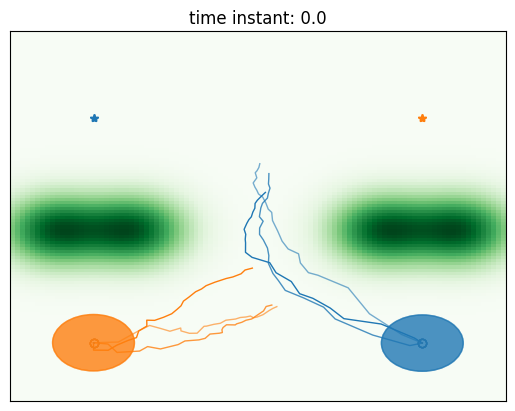

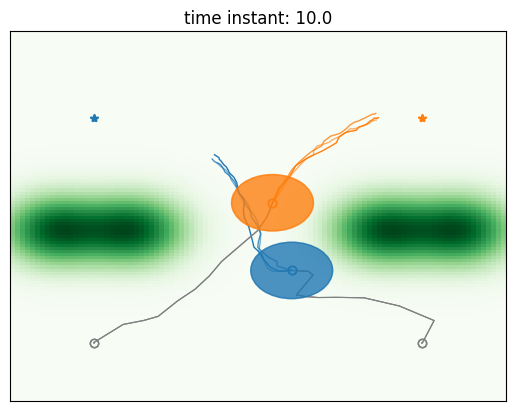

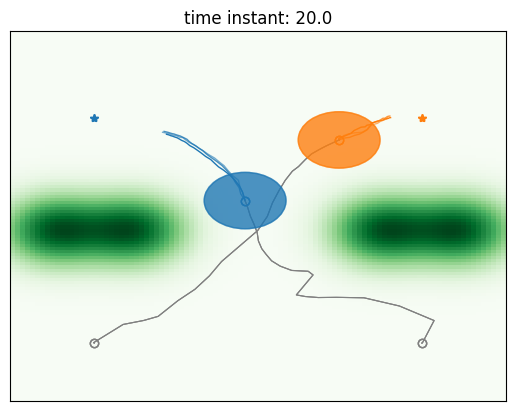

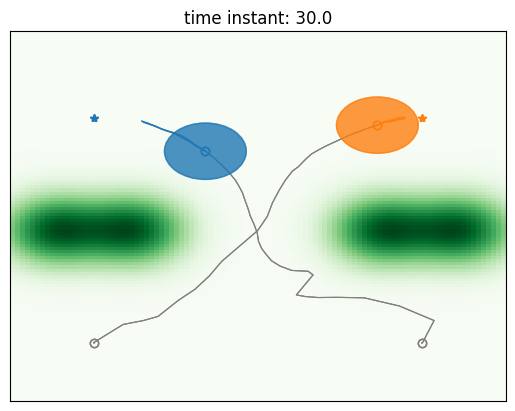

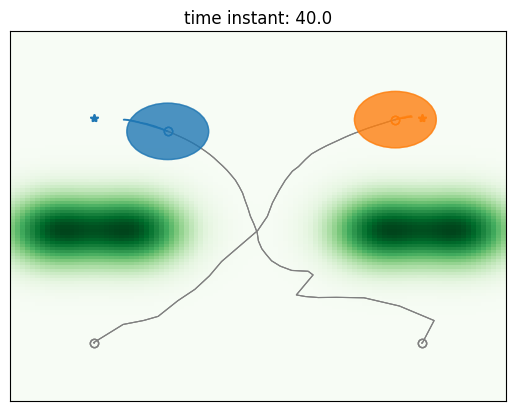

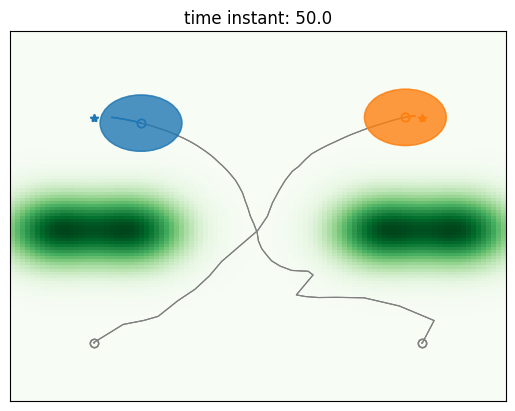

In [6]:
loss_trained = np.zeros(sim_time+1)
tOL = 0

# Data for log
ctlRH = None
x_log = torch.zeros(sim_time+1, syst.n)
u_log = torch.zeros(sim_time, syst.m)
w_in = torch.randn(sim_time + 1, syst.n)
gainM = gamma_bar
x = x0
if x.dtype is not torch.float:
    x = x.to(torch.float)
x_log[0, :] = x0.detach()
xi = torch.zeros(ctl.n)
w_REN = x0.detach() - syst.xbar
u, xi = ctl(0, w_REN, xi)
xiOR = ctl.x0
usys = gainM * u

for tsim in range(sim_time):
    # Compute the next state and control input using the systtem and controller models
    x_ = x
    u_log[tsim, :] = usys.detach()
    gain_log[tsim,:] = (r[tsim] / (gainF * torch.norm(x.detach()-xbar)))-1
    eps_log[tsim,:] = torch.norm(x.detach()-xbar)
    w_sys = disturbance(tsim,w_in_CL[tsim,:],wmaxCL,decayw,maxtimew)
    if tsim == 1 or tsim == 8:
        w_sys = w_sys + delta
    x = syst(tsim, x, usys, w_sys)
    x_log[tsim+1, :] = x.detach()
    w_est = x - syst.f(tsim, x_, usys)

    if (torch.max(w_est)>delta) or( (tsim % timeInstantOpt == 0) ):
        eps = torch.norm(x-syst.xbar)
        gainMt = (r[tsim] / (gainF * eps.detach()))-1
        if (gainMt.item() >0):
            gainM = gainMt
            x0t = x.detach()
            loss_list = np.zeros(epochs)
            if ctlRH is None:
                ctlRH = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
                ctlRH.load_state_dict(torch.load("trained_models/offline_mountains_ctl.pt", weights_only=False))
                ctlRH.set_param()
            state_dict = ctlRH.state_dict()
            state_dict['ctlRH.x0'] = xi.detach()
            ctlRH.set_param()
            optimizer = torch.optim.Adam([{'params': ctlRH.parameters()}], lr=learning_rate)
            for epoch in range(epochs):
                if epoch > 0:
                    del xt,w_int,xit,w_RENt,ut,usyst,loss
                # Reset the gradients of the optimizer
                optimizer.zero_grad()
                loss_x, loss_u, loss_ca, loss_obst = 0, 0, 0, 0
                # Loop over the specified number of trajectories
                xt_log = torch.zeros(Horizon, syst.n, n_traj_ol)
                ut_log = torch.zeros(Horizon, syst.m, n_traj_ol)
                for kk in range(n_traj_ol):
                    w_int = torch.randn((sim_time + Horizon+1, syst.n))
                    devx0 = std_ini * torch.zeros(x0.shape)
                    xt = x0t + devx0
                    xit = xi.detach()
                    w_RENt = x0t.detach() - syst.xbar + devx0
                    ut, xit = ctlRH(0, w_RENt, xit)
                    usyst = gainM * ut
                    for t in range(Horizon):
                        xt_ = xt
                        # Compute the next state and control input using the system and controller models
                        xt_log[t, :,kk] = xt.detach()
                        ut_log[t, :,kk] = usyst.detach()
                        w_syst = disturbance(tsim+t, w_int[tsim+t, :], wmax, decayw, maxtimew)
                        xt = syst(tsim+t, xt, usyst, w_syst)
                        w_RENt = xt - syst.f(tsim+t, xt_, usyst)
                        ut, xit = ctlRH(tsim+t, w_RENt, xit)
                        usyst = gainM * ut
                        # Compute the loss and its components for this time step
                        loss_x = loss_x + f_loss_states(t, xt, syst, Q)
                        loss_u = loss_u + alpha_u * f_loss_u(t, usyst)
                        loss_ca = loss_ca + alpha_ca * f_loss_ca(xt, syst, min_dist)
                        if alpha_obst != 0:
                            loss_obst = loss_obst + alpha_obst * f_loss_obst(xt)
                        if t == Horizon-1:
                            n_traj_tc = 1
                            t_end = sim_time - tsim
                            P = computePriccati(syst, 10*Q,alpha_u*torch.eye(syst.m))
                            loss_x = loss_x + f_loss_states(t, xt, syst, P)

                # Compute the total loss for this epoch and log its components
                loss = loss_x + loss_u + loss_ca + loss_obst
                #print("Epoch: %i --- Loss: %.4f ---||--- Loss x: %.2f --- " % (epoch, loss, loss_x) +
                #      "Loss u: %.2f --- Loss ca: %.2f --- Loss obst: %.2f" % (loss_u, loss_ca, loss_obst) +
                #      " Simulation time: %i "% (tsim))
                loss_list[epoch] = loss.detach()

                # Backpropagate the loss through the controller model and update its parameters
                loss.backward(retain_graph=True)
                optimizer.step()
                ctlRH.set_param()

            if (tsim%10==0 and tsim<60):
                plot_trajectories(xt_log, xbar, syst.n_agents, text="time instant: %.1f" % (tsim),circles=True,  save=False, filename="CL_online Horizon: %.1f " %Horizon , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim+1, min_dist=min_dist)
            
            w_REN = x.detach() - syst.xbar
            xi = torch.zeros(ctl.n)
            u, xi = ctlRH(0, w_REN, xi)
            usys = gainM * u
        else:
            warnings.warn("gain NEGATIVO.", UserWarning)
            w_REN = x - syst.f(tsim, x_, usys)
            u, xi = ctlRH(0, w_REN, xi)
            usys = gainM * u
    else:
        w_REN = x - syst.f(tsim, x_, usys)
        u, xi = ctlRH(tsim, w_REN, xi)
        usys = gainM * u

    loss_trained[tsim+1] = loss_trained[tsim]+f_loss_states(tsim, x, syst, Q)+alpha_u * f_loss_u(tsim, usys)+alpha_ca * f_loss_ca(x, syst, min_dist)+ alpha_obst * f_loss_obst(x)

------- Print pre-trained loop trajectories --------


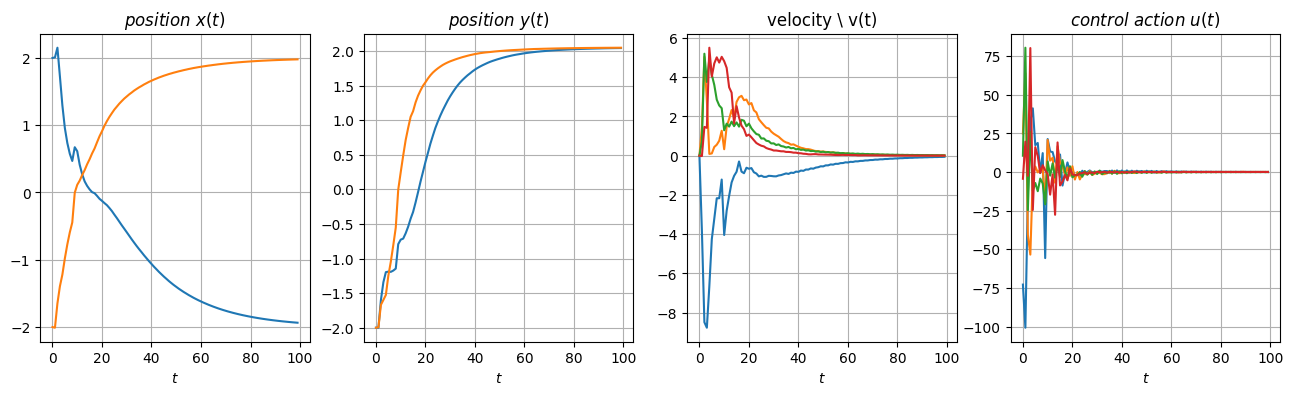

------- Print trained closed-loop trajectories --------


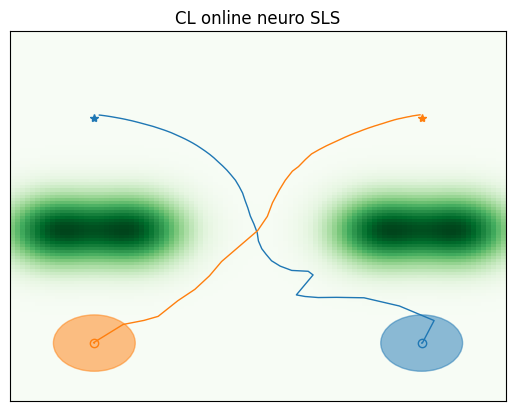

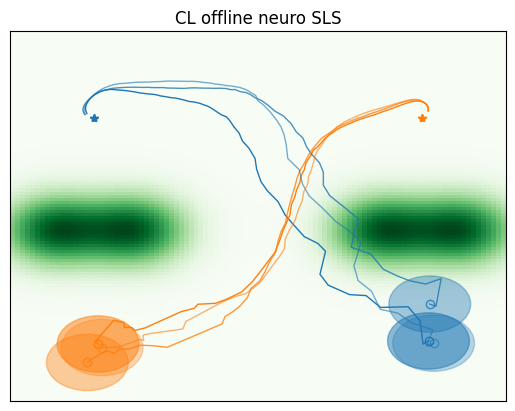

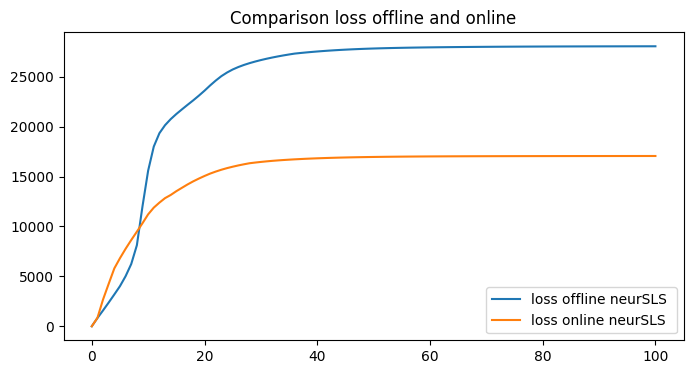

In [13]:
# simulation with closed loop disturbance
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print pre-trained loop trajectories --------")
# Generate random initial conditions for the trajectories
x_log_pre = torch.zeros(sim_time, syst.n,n_traj_ol)
u_log_pre = torch.zeros(sim_time, syst.m,n_traj_ol)
loss_pretrained = np.zeros(sim_time+1)

for traj in range(n_traj_ol):
    devx0 = std_ini * torch.randn(x0.shape)
    w_in = torch.randn(sim_time + 1, syst.n)
    x = x0 + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0 - syst.xbar +devx0
    u, xi = ctl(0, w_REN, xi)
    usys = gamma_bar * u
    for t in range(sim_time):
        x_ = x
        if traj == 0:
            eps_pre = torch.norm(x-xbar)
            r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
        x_log_pre[t, :,traj] = x.detach()
        u_log_pre[t, :,traj] = usys.detach()
        w_syst = disturbance(t,w_in[t,:],wmaxCL,decayw,maxtimew)
        if t == 1 or t == 8:
            w_syst = w_syst + delta
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys)
        u, xi = ctl(t, w_REN, xi)
        usys = gamma_bar * u
        loss_x =  f_loss_states(t, x, syst, Q)
        loss_u = alpha_u * f_loss_u(t, usys)
        loss_ca = alpha_ca * f_loss_ca(x, syst, min_dist)
        if alpha_obst != 0:
            loss_obst =  alpha_obst * f_loss_obst(x)
        loss = loss_x + loss_u + loss_ca + loss_obst
        loss_pretrained[t+1] = loss_pretrained[t]+loss.detach()

plot_traj_vs_time(sim_time, syst.n_agents, x_log[:-1,:], u_log)
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print trained closed-loop trajectories --------")
plot_trajectories(x_log[:,:], xbar, syst.n_agents, text="CL online neuro SLS",save=False , T=sim_time, obst=alpha_obst, circles= True)
plot_trajectories(x_log_pre[:,:], xbar, syst.n_agents, text="CL offline neuro SLS",save=False, T=sim_time, obst=alpha_obst, circles = True)

time = torch.linspace(0, sim_time, sim_time+1)
plt.figure(figsize=(4 * 2, 4))
plt.plot(time, loss_pretrained, label="loss offline neurSLS ")
plt.plot(time, loss_trained, label="loss online neurSLS")
plt.legend()
plt.title('Comparison loss offline and online')
plt.show()